In [19]:
import re
import os
import io
import ast
import gzip
import glob

import numpy as np
import numpy.random as rn
import pandas as pd

import torch
import pyro.distributions as dist

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# import NMF from sklearn
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [2]:
# sometimes use all-caps to denote global variables
DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')

def load_team_data(team, dat_supdir=DATA_SUPDIR):
    # load data
    train_pivot = pd.read_csv(dat_supdir.joinpath(team, 'train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(dat_supdir.joinpath(team, 'test_pivot.csv'), index_col=0)

    # create a single pivot table for all outcomes
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)

    # this is a (timestep x county)-array of all outcomes
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # names of the dates and counties
    dates = total_pivot.index
    county_names = total_pivot.columns

    # make sure that the last county is the stadium county
    assert county_names[-1] == 'Stadium_County'

    # the index of the intervention time
    intervention_t = train_pivot.values.shape[0]

    # make sure that the intervention time is correct
    assert np.allclose(all_outcomes_TN[:intervention_t], train_pivot.values)
    assert np.allclose(all_outcomes_TN[intervention_t:], test_pivot.values)

    return total_pivot, intervention_t

TEAM = 'Indianapolis'
total_pivot, intervention_t = load_team_data(TEAM)
all_outcomes_TN = total_pivot.values
n_timesteps, n_counties = all_outcomes_TN.shape

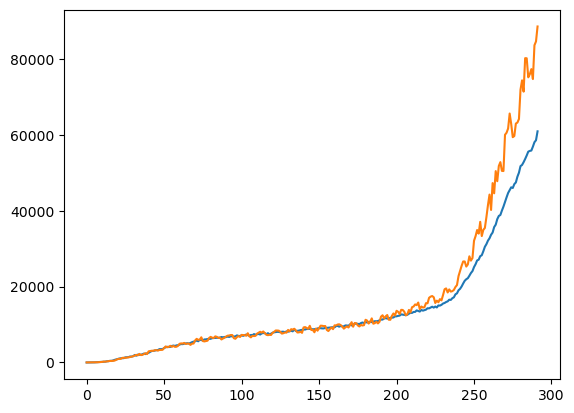

In [136]:
def last_digit(x):
    return int(str(x)[-1])

def create_semi_synthetic_matrix(all_outcomes_TN, intervention_t, alpha=500, n_components=10, seed=617, model_mismatch_p=0.0):
    n_timesteps, n_counties = all_outcomes_TN.shape

    # fit NMF to the training data
    nmf = NMF(n_components=n_components, init='random', random_state=seed, max_iter=5000)
    W_TK = nmf.fit_transform(all_outcomes_TN)
    H_KN = nmf.components_

    Mu_TN = W_TK @ H_KN

    rn.seed(seed)
    synth_all_outcomes_TN = rn.poisson(Mu_TN)
    if model_mismatch_p > 0.0:
        for t in range(1, n_timesteps):
            innovation_t = 0.9 + rn.beta(1 + 2 * int(last_digit(t) < 5), 1 + 2 * int(last_digit(t) >= 5)) * 0.2  # always between [0.9, 1.1]
            Mu_TN[t] = (1-model_mismatch_p) * Mu_TN[t] + model_mismatch_p * (synth_all_outcomes_TN[t-1] * innovation_t)

    true_counterfactuals = Mu_TN[intervention_t:, -1]
    Mu_TN[intervention_t:, -1] *= (1 + np.log1p(np.arange(n_timesteps - intervention_t))) ** (np.arange(n_timesteps - intervention_t)/alpha)
    return rn.poisson(Mu_TN), Mu_TN, true_counterfactuals

synth_all_outcomes_TN, Mu_TN, true_counterfactuals = create_semi_synthetic_matrix(all_outcomes_TN, intervention_t, alpha=500, seed=617, model_mismatch_p=0.75)

plt.plot(all_outcomes_TN[:, -1])
plt.plot(synth_all_outcomes_TN[:, -1])


In [94]:
# get last digit of int
def last_digit(x):
    return int(str(x)[-1])

5

In [140]:
# sometimes use all-caps to denote global variables
SYNTH_DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/')

for team_dir in tqdm(DATA_SUPDIR.dirs()):
    team = team_dir.basename()

    total_pivot, intervention_t = load_team_data(team)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    
    for model_mismatch_p in [0, 10, 25, 50, 75, 100]:
        for alpha in [250, 500, 100000]:
            for seed in [617]:
                synth_all_outcomes_TN, Mu_TN, true_counterfactuals = create_semi_synthetic_matrix(all_outcomes_TN, 
                                                                                                  intervention_t, 
                                                                                                  alpha=alpha, 
                                                                                                  seed=seed, 
                                                                                                  model_mismatch_p=model_mismatch_p/100.)
                # set the values of the pandas dataframe
                synth_total_pivot = total_pivot.copy()
                synth_total_pivot.iloc[:,:] = synth_all_outcomes_TN
                assert np.allclose(synth_total_pivot.values, synth_all_outcomes_TN)

                out_dir = SYNTH_DATA_SUPDIR.joinpath(team, f'model_mismatch_p_{model_mismatch_p}', f'alpha_{alpha}', f'seed_{seed}')
                out_dir.makedirs_p()

                synth_total_pivot.iloc[:intervention_t].to_csv(out_dir.joinpath('train_pivot.csv'))
                synth_total_pivot.iloc[intervention_t:].to_csv(out_dir.joinpath('test_pivot.csv'))

                np.savez_compressed(out_dir.joinpath('ground_truth_rates.npz'), Mu_TN=Mu_TN, true_counterfactuals=true_counterfactuals)
                

  0%|          | 0/31 [00:00<?, ?it/s]

/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/home/schein/miniconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve conve

In [107]:
for team_dir in tqdm(DATA_SUPDIR.dirs()):
    team = team_dir.basename()

    total_pivot, intervention_t = load_team_data(team)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape
    if n_counties > 50:
        print(team, n_timesteps, n_counties)

  0%|          | 0/31 [00:00<?, ?it/s]

Atlanta 305 142
Green Bay 289 58
Pittsburgh 293 52
Cleveland 298 72
San Francisco 336 54
Detroit 297 82
Buffalo 292 52
Kansas City 300 86
Tennessee 302 85
Dallas 297 212
Houston 302 212
LA Chargers 341 54
Cincinnati 288 72
New Orleans 297 64
Philadelphia 297 52
Indianapolis 301 84
Minnesota 301 84
Chicago 343 101
LA Rams 341 54
Carolina 295 91


## Analyze results

In [135]:
def get_reg_arrays(Z, all_outcomes_TN, intervention_t, counterfactual=False, include_previous_outcome=False):
    latent_dim, n_counties = Z.shape
    assert all_outcomes_TN.shape[1] == n_counties
    all_outcomes_NT = all_outcomes_TN.T

    A = np.zeros((n_counties, 1))
    if not counterfactual:
        A[-1] = 1
    
    if include_previous_outcome:
        # Y_{i,t} ~ A + Z_i + Y_{i,-1} 

        B = np.array(all_outcomes_NT[:, intervention_t-1])[:, np.newaxis]
        X = np.concatenate([Z.T, B, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 2)
    else:
        X = np.concatenate([Z.T, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 1)

    Y = np.array(all_outcomes_NT[:, intervention_t:])
    return X, Y


def get_counterfactual_from_best_reg(Z, all_outcomes_TN, intervention_t, include_previous_outcome=True,
                                     reg_type='Ridge', reg_params={"alpha": [0, 1e-4,1e-3, 1e-2]}):
    
    X, Y = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome)

    if reg_type == 'Ridge':
        reg = Ridge()
    elif reg_type == 'MLP': 
        reg = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
    elif reg_type == 'Lasso':
        reg = Lasso()
    
    cv = GridSearchCV(reg, reg_params, scoring='r2', cv=5)
    cv_results = cv.fit(X, Y)
    best_reg = cv_results.best_estimator_

    X, _ = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome, counterfactual=True)
    return best_reg.predict(X)[-1], best_reg  # return only affected county and model


In [138]:
SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat')

# find posterior_sample_file
posterior_sample_files = list(SYNTH_SUPDIR.walkfiles('*posterior_samples.npz'))
posterior_sample_file = posterior_sample_files[0]
posterior_samples = np.load(posterior_sample_file)
Z_samples = posterior_samples['Z']

# walk back up the path to get the data
synth_data_dir = posterior_sample_file.parent
while synth_data_dir.basename() != 'synth_dat':
    if synth_data_dir.joinpath('train_pivot.csv').exists():
        break
    synth_data_dir = synth_data_dir.parent

# load the data
train_pivot = pd.read_csv(synth_data_dir.joinpath('train_pivot.csv'), index_col=0)
test_pivot = pd.read_csv(synth_data_dir.joinpath('test_pivot.csv'), index_col=0)
total_pivot = pd.concat([train_pivot, test_pivot], axis=0)
all_outcomes_TN = total_pivot.values
n_timesteps, n_counties = all_outcomes_TN.shape
intervention_t = train_pivot.values.shape[0]
true_counterfactuals = np.load(synth_data_dir.joinpath('ground_truth_rates.npz'))['true_counterfactuals']

# get team name, model, etc from path
subdirs = synth_data_dir.splitall()
seed = int(subdirs[-1].split('_')[-1])
alpha = int(subdirs[-2].split('_')[-1])
model_mismatch_p = int(subdirs[-3].split('_')[-1])/100.
team = subdirs[-4]

# compute counterfactuals for every posterior sample using Ridge regression

reg_type = 'Ridge'
include_previous_outcome = True

counterfactual_preds = []
for Z in Z_samples:
    cf_pred, best_reg = get_counterfactual_from_best_reg(Z,
                                                         reg_type=reg_type,
                                                         all_outcomes_TN=all_outcomes_TN, 
                                                         intervention_t=intervention_t, 
                                                         include_previous_outcome=include_previous_outcome)
    counterfactual_preds.append(cf_pred)
counterfactual_preds = np.array(counterfactual_preds)

FileNotFoundError: [Errno 2] No such file or directory: Path('/net/projects/schein-lab/jshou/synth_dat/Buffalo/model_mismatch_p_10/alpha_500/seed_617/ground_truth_rates.npz')

In [139]:
ls /net/projects/schein-lab/jshou/synth_dat/Buffalo/model_mismatch_p_10/alpha_500/seed_617/


results/  test_pivot.csv  train_pivot.csv


In [129]:
subdirs = posterior_sample_file.splitall()
subdirs = subdirs[subdirs.index('synth_dat')+1:]
team = subdirs['']

['Buffalo',
 'model_mismatch_p_10',
 'alpha_500',
 'seed_617',
 'results',
 'GAP',
 'latent_dim10',
 'seed_617',
 'posterior_samples.npz']

In [128]:
posterior_sample_file.splitpath()


(Path('/net/projects/schein-lab/jshou/synth_dat/Buffalo/model_mismatch_p_10/alpha_500/seed_617/results/GAP/latent_dim10/seed_617'),
 'posterior_samples.npz')